# Point Process Analysis Aggregation
A framework for evaluating the performance of centroid and proportional allocation approaches.

In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

from src.aggregation import *
from src.point_processes_1d import *
from src.visualization import *
from src.simulation import *
import matplotlib.pyplot as plt
import numpy as np
N = 1000
# dg = np.linspace(0.01, 0.99, N)
# dg = np.logspace(-3, -0.01, N)
dg = np.logspace(-3, -0.01, N)
# dg = np.logspace(-3, 0.693, N)
dp = 0.5*np.ones(N)
ratio = dp / dg
rate = 100
start = -3
end = 4


# Empirical evaluation of homogeneous and non-homogeneous point process
Empirically compare proportional allocation and centroid allocation approaches under three forms of point process:
1. Homogeneous Poisson point process
2. Non-homogeneous Neyman Scott process
3. Non-homogeneous Log-Gaussian Cox process

### Generate samples from each type of point process

In [2]:
# Parameters for Poisson Process
N = 200

# Parameters for Neyman-Scott Process
lambda_p = 10
lambda_c = N / lambda_p
sigma = 0.05

# Parameters for log-Gaussian Cox Process
L = 1             # Length of domain
dx = 0.01          # Bin width
mean_log_intensity = np.log(N)  # Mean of log-intensity
variance = 1     # Variance of the Gaussian Process
length_scale = 0.05 # Length scale of covariance

sample_generator = {}
sample_generator['poisson'] = lambda x, start, end: get_poisson_process_samples(x, start, end)
sample_generator['neyman-scott'] = lambda x, start, end: get_neyman_scott_process(lambda_p, x / lambda_p, sigma, start, end)
sample_generator['lgcp'] = lambda x, start, end: get_log_gaussian_cox_process(dx, np.log(x), variance, length_scale, start, end)

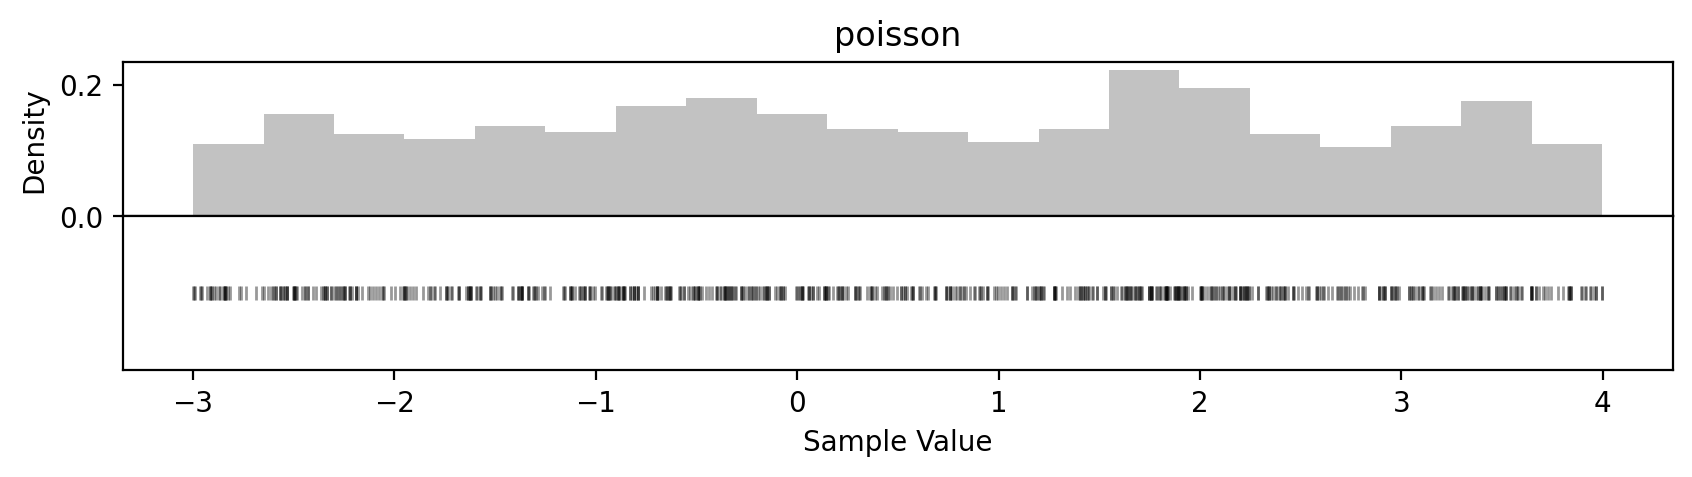

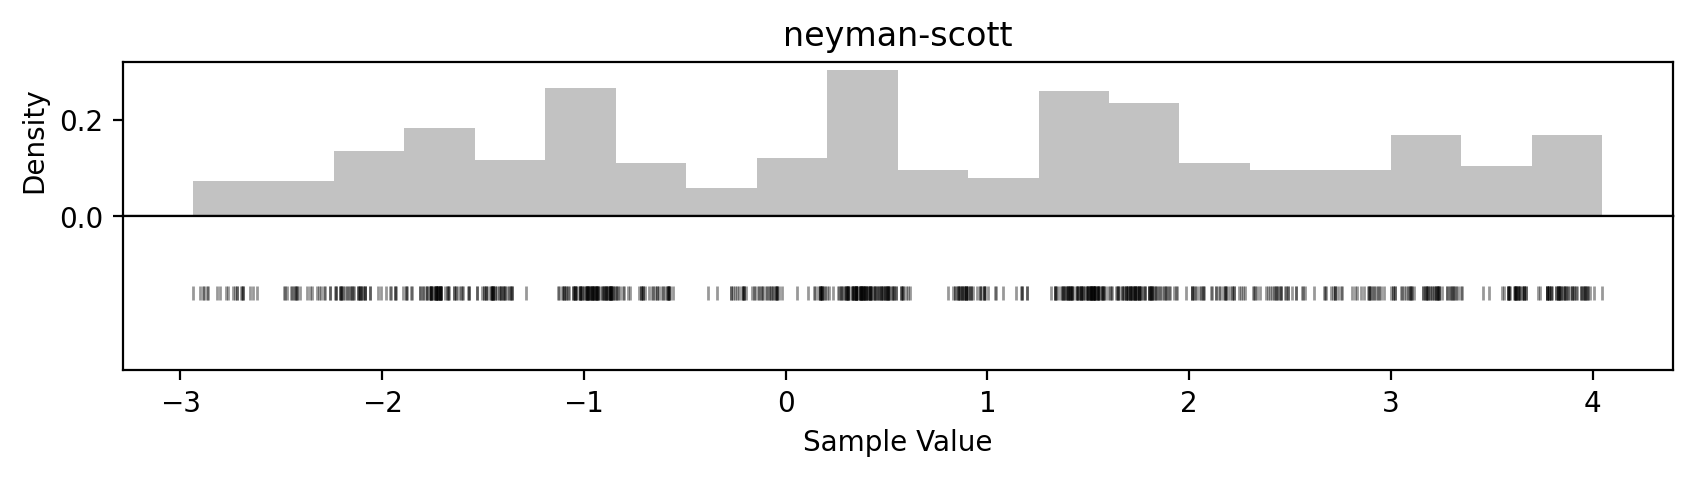

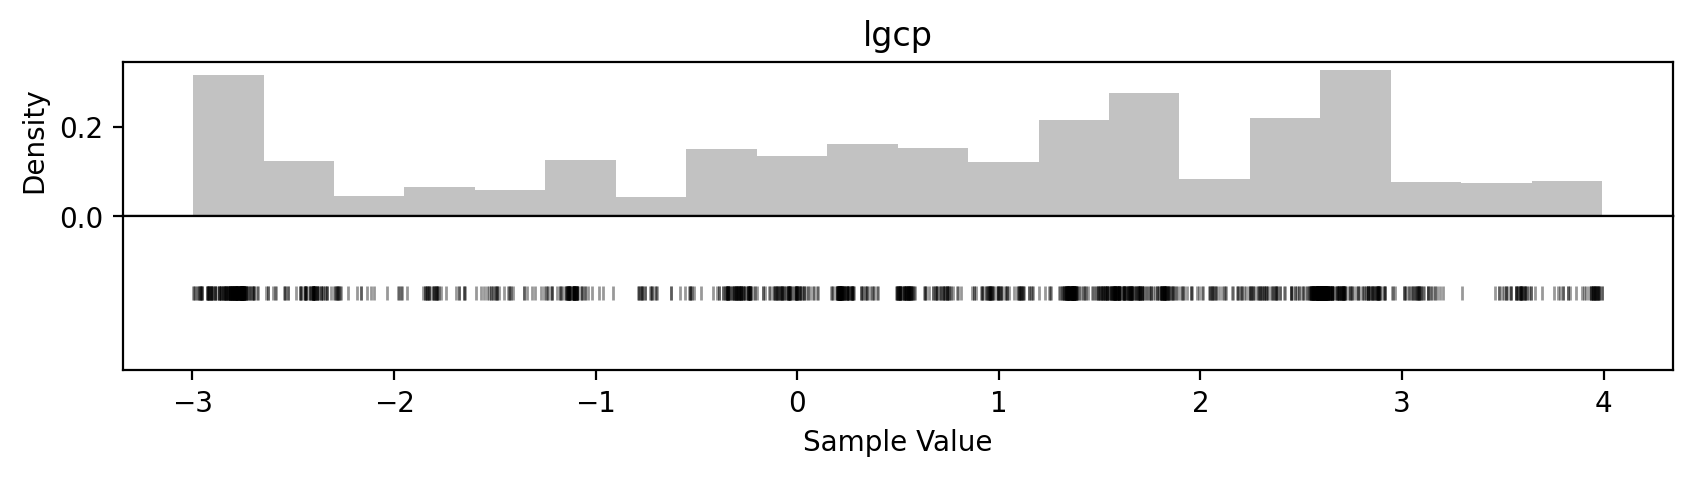

In [ ]:
# Plot the samples
for key in sample_generator.keys():
    # Generate samples
    samples = sample_generator[key](rate, start, end)
    plot_one_d_samples(samples, key)


### Run the simulation for one of the point processes assuming the one edge is fixed at $x=0$

In [4]:
from tqdm import tqdm

# Distribution under test:
point_process = sample_generator['poisson']
trials = 500

# Run many iterations to get a distribution of the estimates
mean_estimate_centroid = []
var_estimate_centroid = []
mean_estimate_proportional = []
var_estimate_proportional = []
mean_mape_proportional = []
mean_mape_centroid = []
for grid_width, polygon_width in tqdm(zip(dg, dp),  total=len(dg)):
    errors_centroid = []
    errors_proportional = []
    mape_centroid = []
    mape_proportional = []
    
    for _ in range(trials):
        data = point_process(rate, start, end)
        # count, edges = create_gridded_data(data, grid_width, start, end)
        count, edges = create_gridded_data(data, grid_width, 0, 1)
        actual_value = get_actual_value(data, 0, polygon_width)
        estimate_centroid = centroid_allocation_estimate(count, edges, 0, polygon_width)
        estimate_proportional = proportional_allocation_estimate(count, edges, 0, polygon_width)
        errors_centroid.append(estimate_centroid - actual_value)
        errors_proportional.append(estimate_proportional - actual_value)
        if actual_value != 0:
            mape_centroid.append(np.abs(estimate_centroid - actual_value) / actual_value * 100)
            mape_proportional.append(np.abs(estimate_proportional - actual_value) / actual_value * 100)

    # Calculate mean and variance of the estimates
    mean_estimate_centroid.append(np.mean(errors_centroid))
    var_estimate_centroid.append(np.var(errors_centroid))
    mean_estimate_proportional.append(np.mean(errors_proportional))
    var_estimate_proportional.append(np.var(errors_proportional))
    mean_mape_centroid.append(np.mean(mape_centroid))
    mean_mape_proportional.append(np.mean(mape_proportional))

100%|██████████| 1000/1000 [00:28<00:00, 35.15it/s]


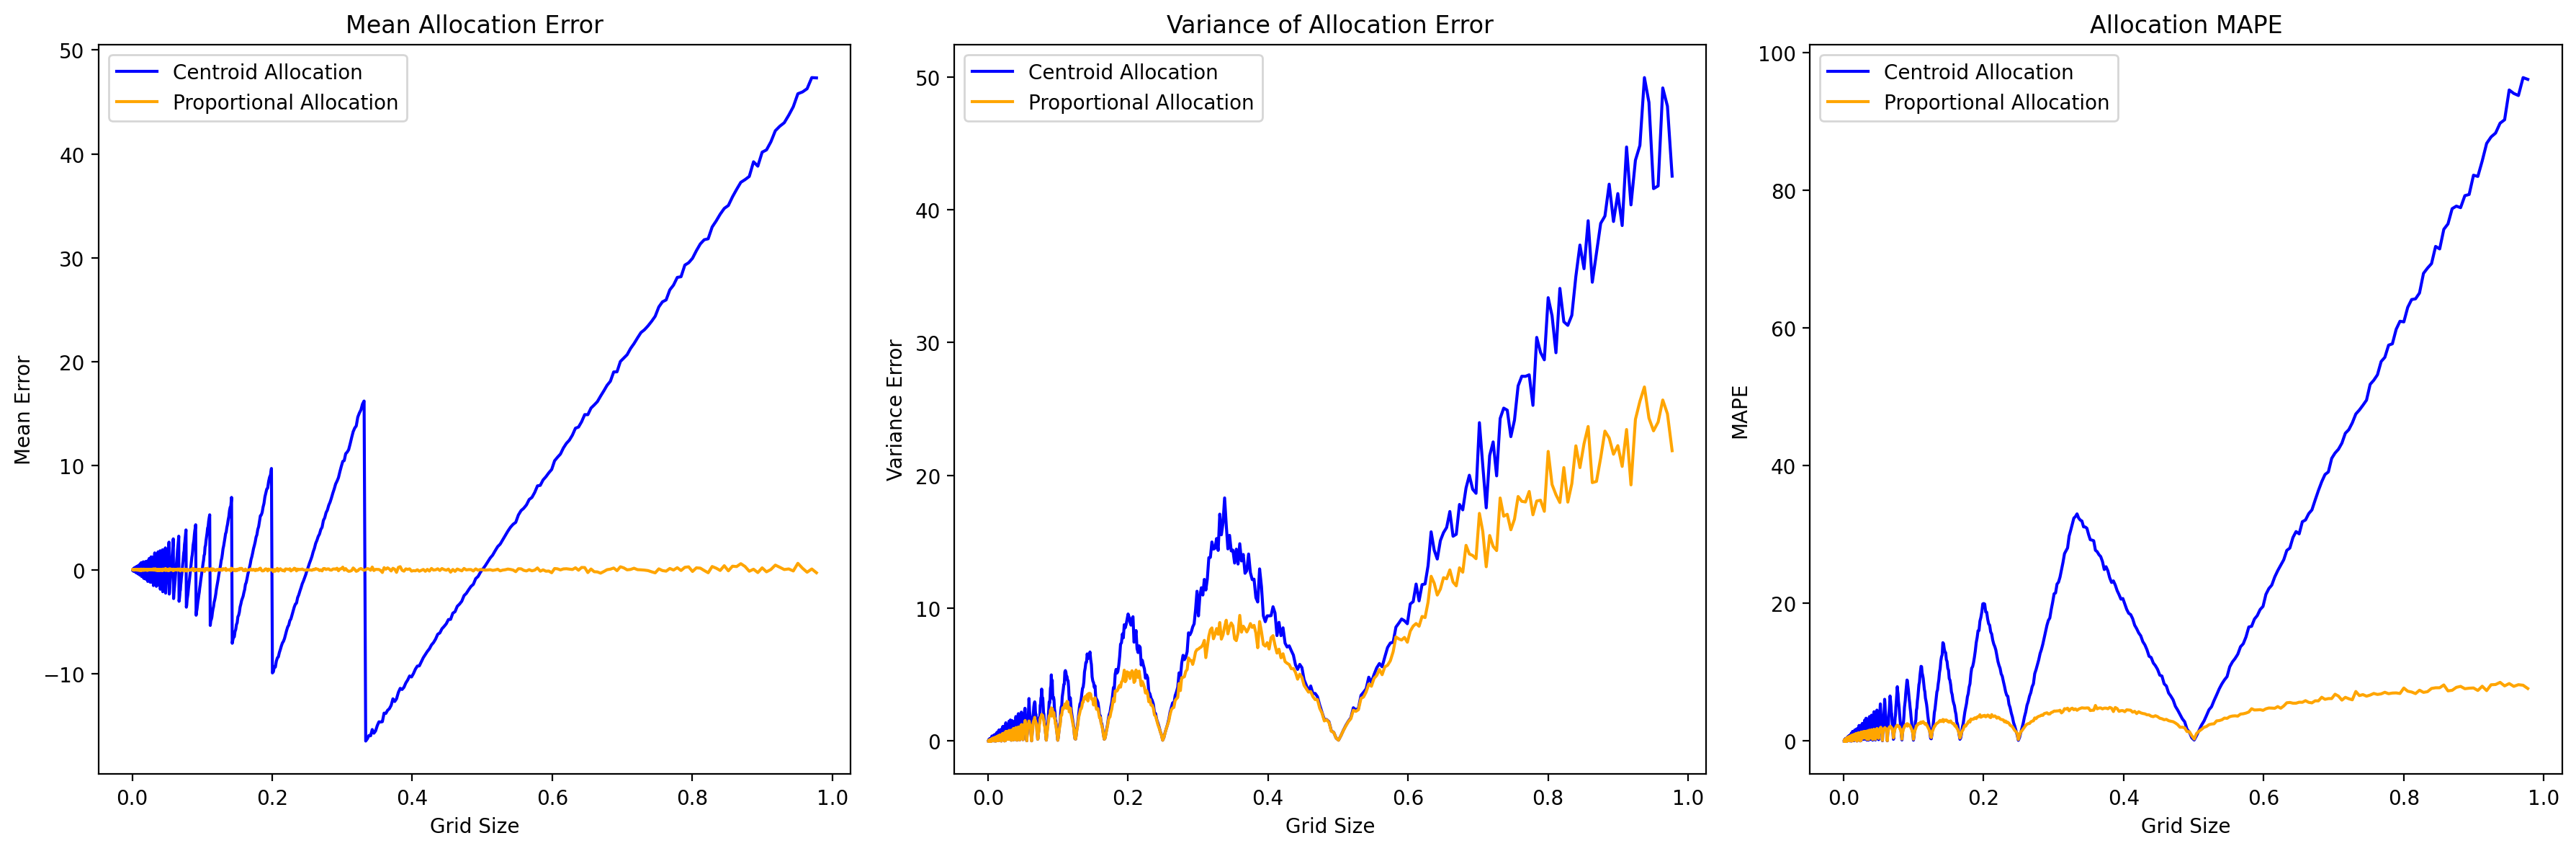

In [5]:
# Plot the resulting mean and variance of the estimates
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].plot(dg, mean_estimate_centroid, label='Centroid Allocation', color='blue')
ax[0].plot(dg, mean_estimate_proportional, label='Proportional Allocation', color='orange')
ax[0].set_title('Mean Allocation Error')
ax[0].set_xlabel('Grid Size')
ax[0].set_ylabel('Mean Error')
ax[0].legend()
ax[1].plot(dg, var_estimate_centroid, label='Centroid Allocation', color='blue')
ax[1].plot(dg, var_estimate_proportional, label='Proportional Allocation', color='orange')
ax[1].set_title('Variance of Allocation Error')
ax[1].set_xlabel('Grid Size')
ax[1].set_ylabel('Variance Error')
ax[1].legend()
ax[2].plot(dg, mean_mape_centroid, label='Centroid Allocation', color='blue')
ax[2].plot(dg, mean_mape_proportional, label='Proportional Allocation', color='orange')
ax[2].set_title('Allocation MAPE')
ax[2].set_xlabel('Grid Size')
ax[2].set_ylabel('MAPE')
ax[2].legend()
plt.tight_layout()
plt.show()

### Run the simulation for one of the point processes randomly setting the edges

In [6]:
from tqdm import tqdm

# Distribution under test:
point_process = 'poisson'

# Run many iterations to get a distribution of the estimates
trials = 500
mean_estimate_centroid = []
var_estimate_centroid = []
mean_estimate_proportional = []
var_estimate_proportional = []
mean_mape_proportional = []
mean_mape_centroid = []
for grid_width, polygon_width in tqdm(zip(dg, dp),  total=len(dg)):
    errors_centroid = []
    errors_proportional = []
    mape_centroid = []
    mape_proportional = []
    
    for _ in range(trials):
        # Generate polygon
        # polygon_start = np.random.uniform(low=0 - polygon_width, high=1 + polygon_width)
        polygon_start = np.random.uniform(low=-1, high=2)
        polygon_end = polygon_start + polygon_width
        
        data = sample_generator[point_process](rate, start, end)
        count, edges = create_gridded_data(data, grid_width, start, end)
        actual_value = get_actual_value(data, polygon_start, polygon_end)

        estimate_centroid = centroid_allocation_estimate(count, edges, polygon_start, polygon_end)
        estimate_proportional = proportional_allocation_estimate(count, edges, polygon_start, polygon_end)
        errors_centroid.append(estimate_centroid - actual_value)
        errors_proportional.append(estimate_proportional - actual_value)
        if actual_value != 0:
            mape_centroid.append(np.abs(estimate_centroid - actual_value) / actual_value * 100)
            mape_proportional.append(np.abs(estimate_proportional - actual_value) / actual_value * 100)
        # else:
        #     mape_centroid.append(0)
        #     mape_proportional.append(0)

    # Calculate mean and variance of the estimates
    mean_estimate_centroid.append(np.mean(errors_centroid))
    var_estimate_centroid.append(np.var(errors_centroid))
    mean_estimate_proportional.append(np.mean(errors_proportional))
    var_estimate_proportional.append(np.var(errors_proportional))
    mean_mape_centroid.append(np.mean(mape_centroid))
    mean_mape_proportional.append(np.mean(mape_proportional))


100%|██████████| 1000/1000 [00:40<00:00, 24.94it/s]


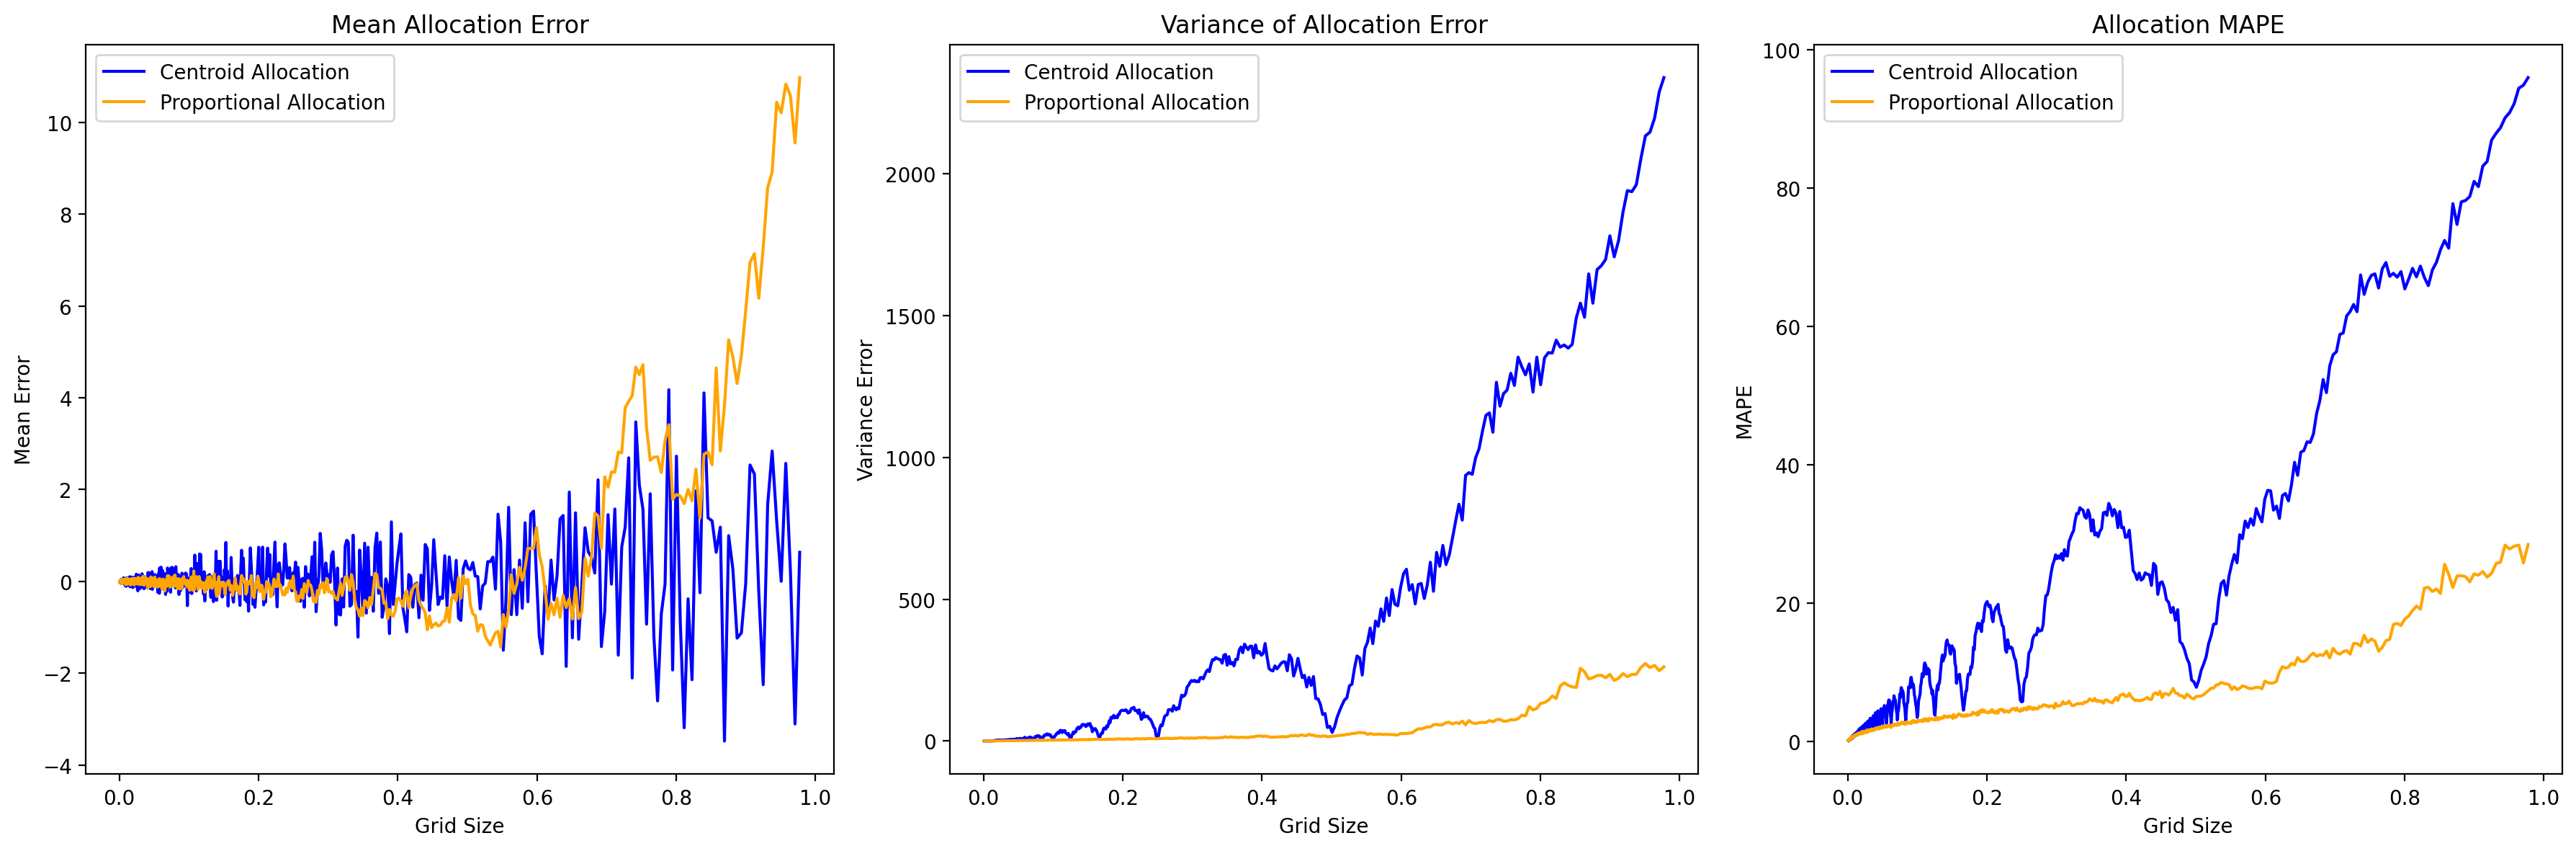

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].plot(dg, mean_estimate_centroid, label='Centroid Allocation', color='blue')
ax[0].plot(dg, mean_estimate_proportional, label='Proportional Allocation', color='orange')
ax[0].set_title('Mean Allocation Error')
ax[0].set_xlabel('Grid Size')
ax[0].set_ylabel('Mean Error')
ax[0].legend()
ax[1].plot(dg, var_estimate_centroid, label='Centroid Allocation', color='blue')
ax[1].plot(dg, var_estimate_proportional, label='Proportional Allocation', color='orange')
ax[1].set_title('Variance of Allocation Error')
ax[1].set_xlabel('Grid Size')
ax[1].set_ylabel('Variance Error')
ax[1].legend()
ax[2].plot(dg, mean_mape_centroid, label='Centroid Allocation', color='blue')
ax[2].plot(dg, mean_mape_proportional, label='Proportional Allocation', color='orange')
ax[2].set_title('Allocation MAPE')
ax[2].set_xlabel('Grid Size')
ax[2].set_ylabel('MAPE')
ax[2].legend()
plt.tight_layout()
plt.show()

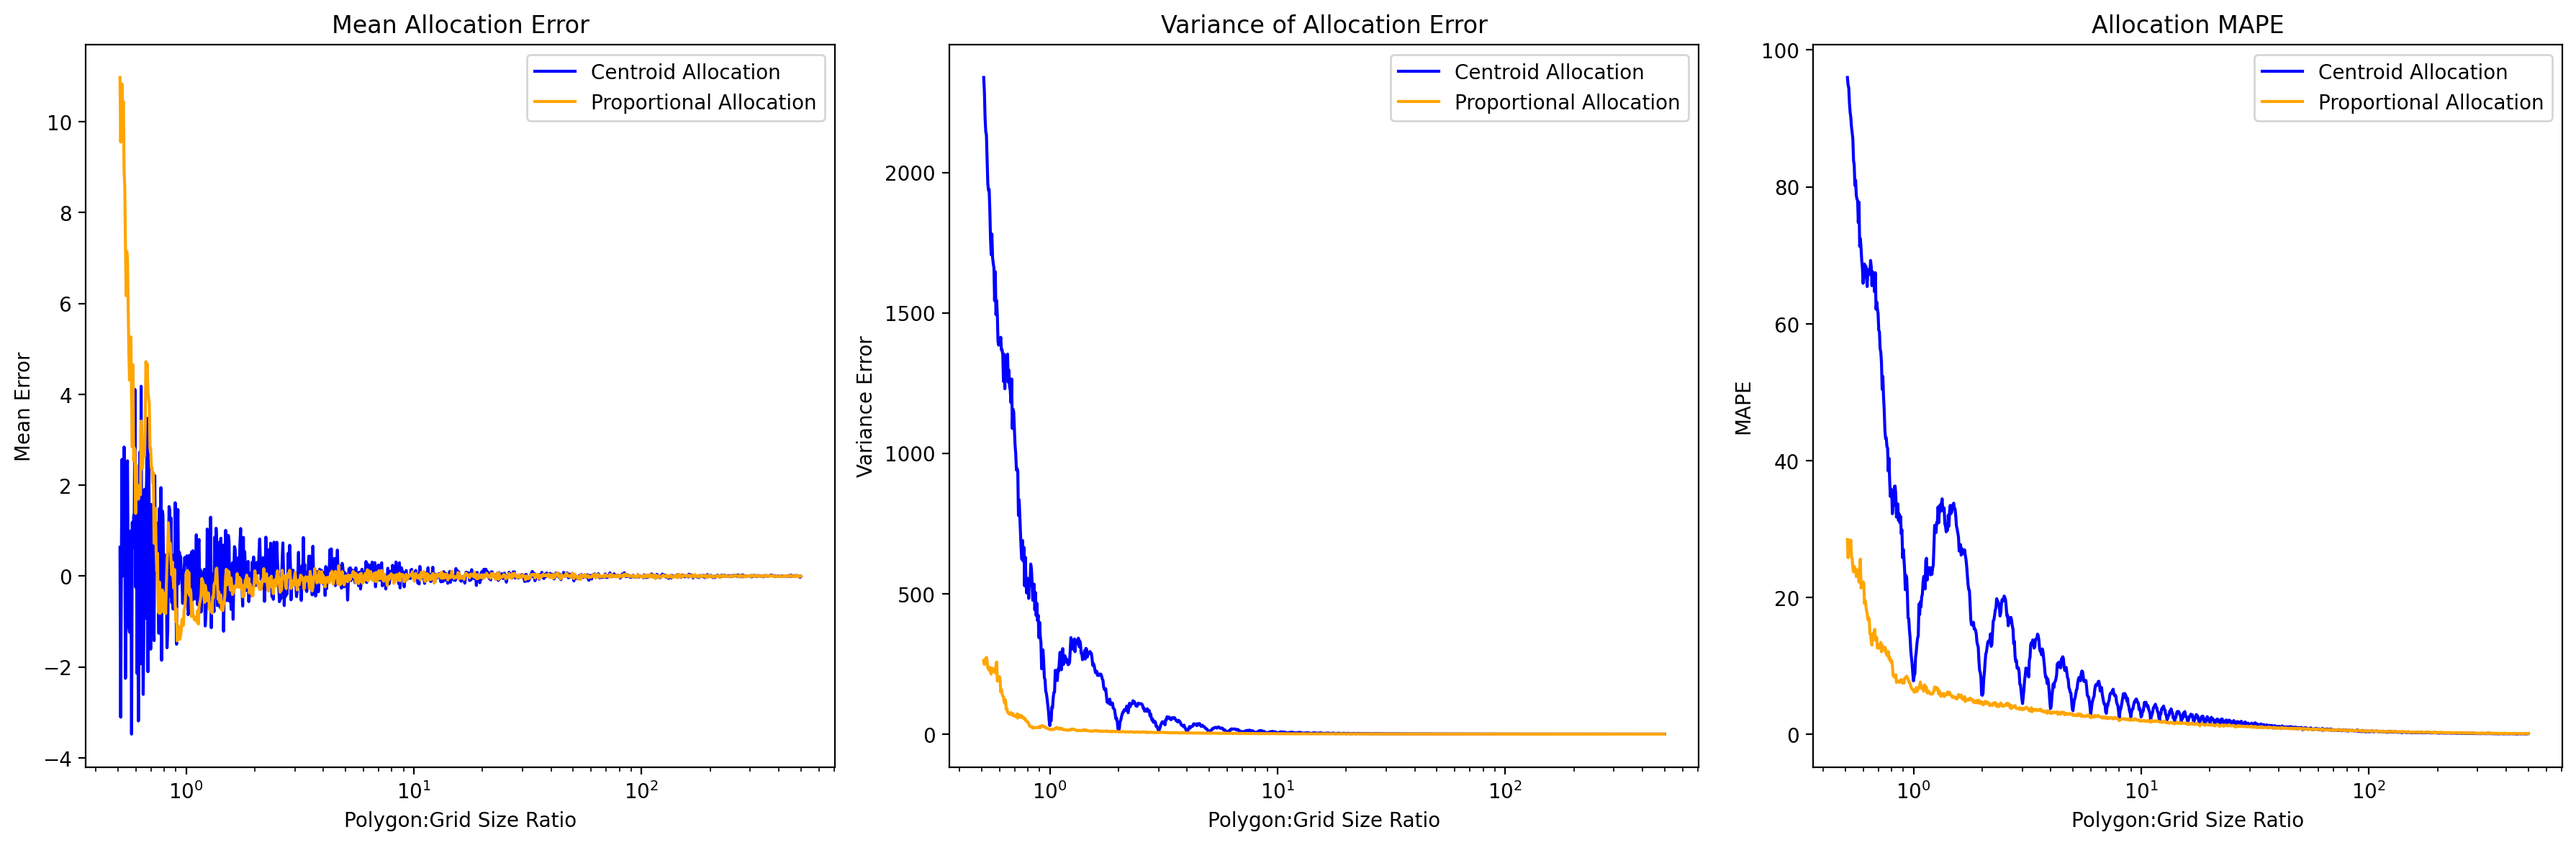

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].semilogx(dp/dg, mean_estimate_centroid, label='Centroid Allocation', color='blue')
ax[0].semilogx(dp/dg, mean_estimate_proportional, label='Proportional Allocation', color='orange')
ax[0].set_title('Mean Allocation Error')
ax[0].set_xlabel('Polygon:Grid Size Ratio')
ax[0].set_ylabel('Mean Error')
ax[0].legend()
ax[1].semilogx(dp/dg, var_estimate_centroid, label='Centroid Allocation', color='blue')
ax[1].semilogx(dp/dg, var_estimate_proportional, label='Proportional Allocation', color='orange')
ax[1].set_title('Variance of Allocation Error')
ax[1].set_xlabel('Polygon:Grid Size Ratio')
ax[1].set_ylabel('Variance Error')
ax[1].legend()
ax[2].semilogx(dp/dg, mean_mape_centroid, label='Centroid Allocation', color='blue')
ax[2].semilogx(dp/dg, mean_mape_proportional, label='Proportional Allocation', color='orange')
ax[2].set_title('Allocation MAPE')
ax[2].set_xlabel('Polygon:Grid Size Ratio')
ax[2].set_ylabel('MAPE')
ax[2].legend()
plt.tight_layout()
plt.show()

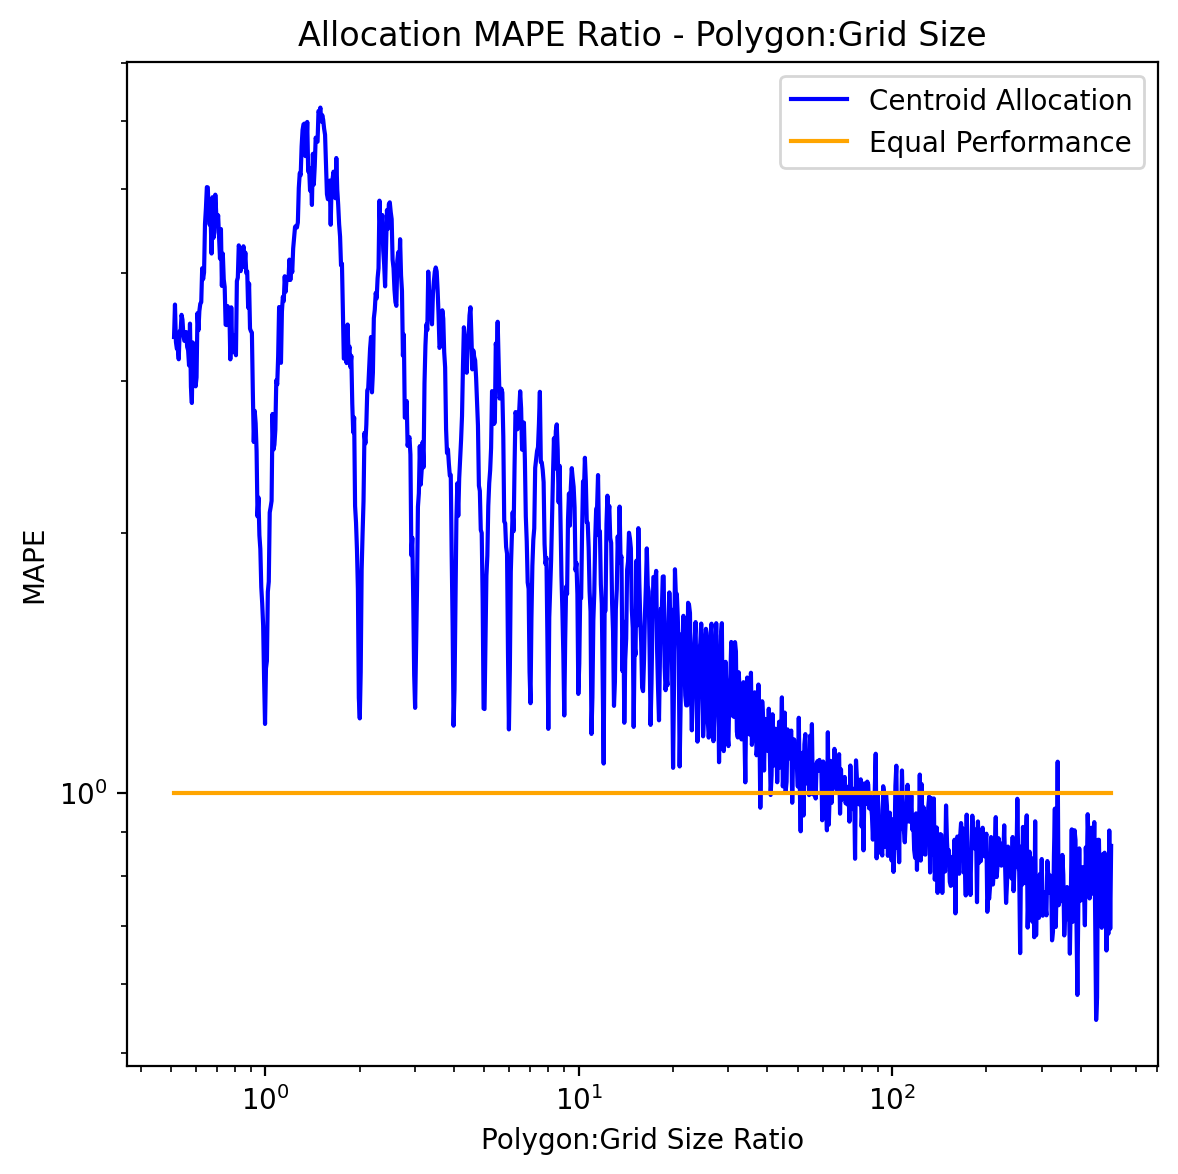

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.loglog(dp/dg, np.array(mean_mape_centroid) / np.array(mean_mape_proportional), label='MAPE Ratio - Centroid:Proportional', color='blue')
ax.loglog(dp/dg, np.ones(len(dg)), label='Equal Performance', color='darkgray', linestyle='--')
ax.set_title('Allocation MAPE Ratio - Centroid:Proportional Allocation')
ax.set_xlabel('Polygon:Grid Size Ratio')
ax.set_ylabel('MAPE')
ax.legend()
plt.tight_layout()
plt.show()

## Allow the grid to randomly vary it's origin

In [21]:
from tqdm import tqdm

# Distribution under test:
# point_process = 'poisson'
point_process = 'neyman-scott'

# Run many iterations to get a distribution of the estimates
trials = 5000
mean_estimate_centroid = []
var_estimate_centroid = []
mean_estimate_proportional = []
var_estimate_proportional = []
mean_mape_proportional = []
mean_mape_centroid = []
for grid_width, polygon_width in tqdm(zip(dg, dp),  total=len(dg)):
    errors_centroid = []
    errors_proportional = []
    mape_centroid = []
    mape_proportional = []
    
    for _ in range(trials):
        # Generate polygon
        # polygon_start = np.random.uniform(low=0 - polygon_width, high=1 + polygon_width)
        polygon_start = np.random.uniform(low=-1, high=2)
        polygon_end = polygon_start + polygon_width
        
        data = sample_generator[point_process](rate, start, end)
        count, edges = create_gridded_data_random_origin(data, grid_width, start, end, range_of_variation=polygon_width)
        actual_value = get_actual_value(data, polygon_start, polygon_end)

        estimate_centroid = centroid_allocation_estimate(count, edges, polygon_start, polygon_end)
        estimate_proportional = proportional_allocation_estimate(count, edges, polygon_start, polygon_end)
        errors_centroid.append(estimate_centroid - actual_value)
        errors_proportional.append(estimate_proportional - actual_value)
        if actual_value != 0:
            mape_centroid.append(np.abs(estimate_centroid - actual_value) / actual_value * 100)
            mape_proportional.append(np.abs(estimate_proportional - actual_value) / actual_value * 100)
        # else:
        #     mape_centroid.append(0)
        #     mape_proportional.append(0)

    # Calculate mean and variance of the estimates
    mean_estimate_centroid.append(np.mean(errors_centroid))
    var_estimate_centroid.append(np.var(errors_centroid))
    mean_estimate_proportional.append(np.mean(errors_proportional))
    var_estimate_proportional.append(np.var(errors_proportional))
    mean_mape_centroid.append(np.mean(mape_centroid))
    mean_mape_proportional.append(np.mean(mape_proportional))

100%|██████████| 1000/1000 [19:58<00:00,  1.20s/it]


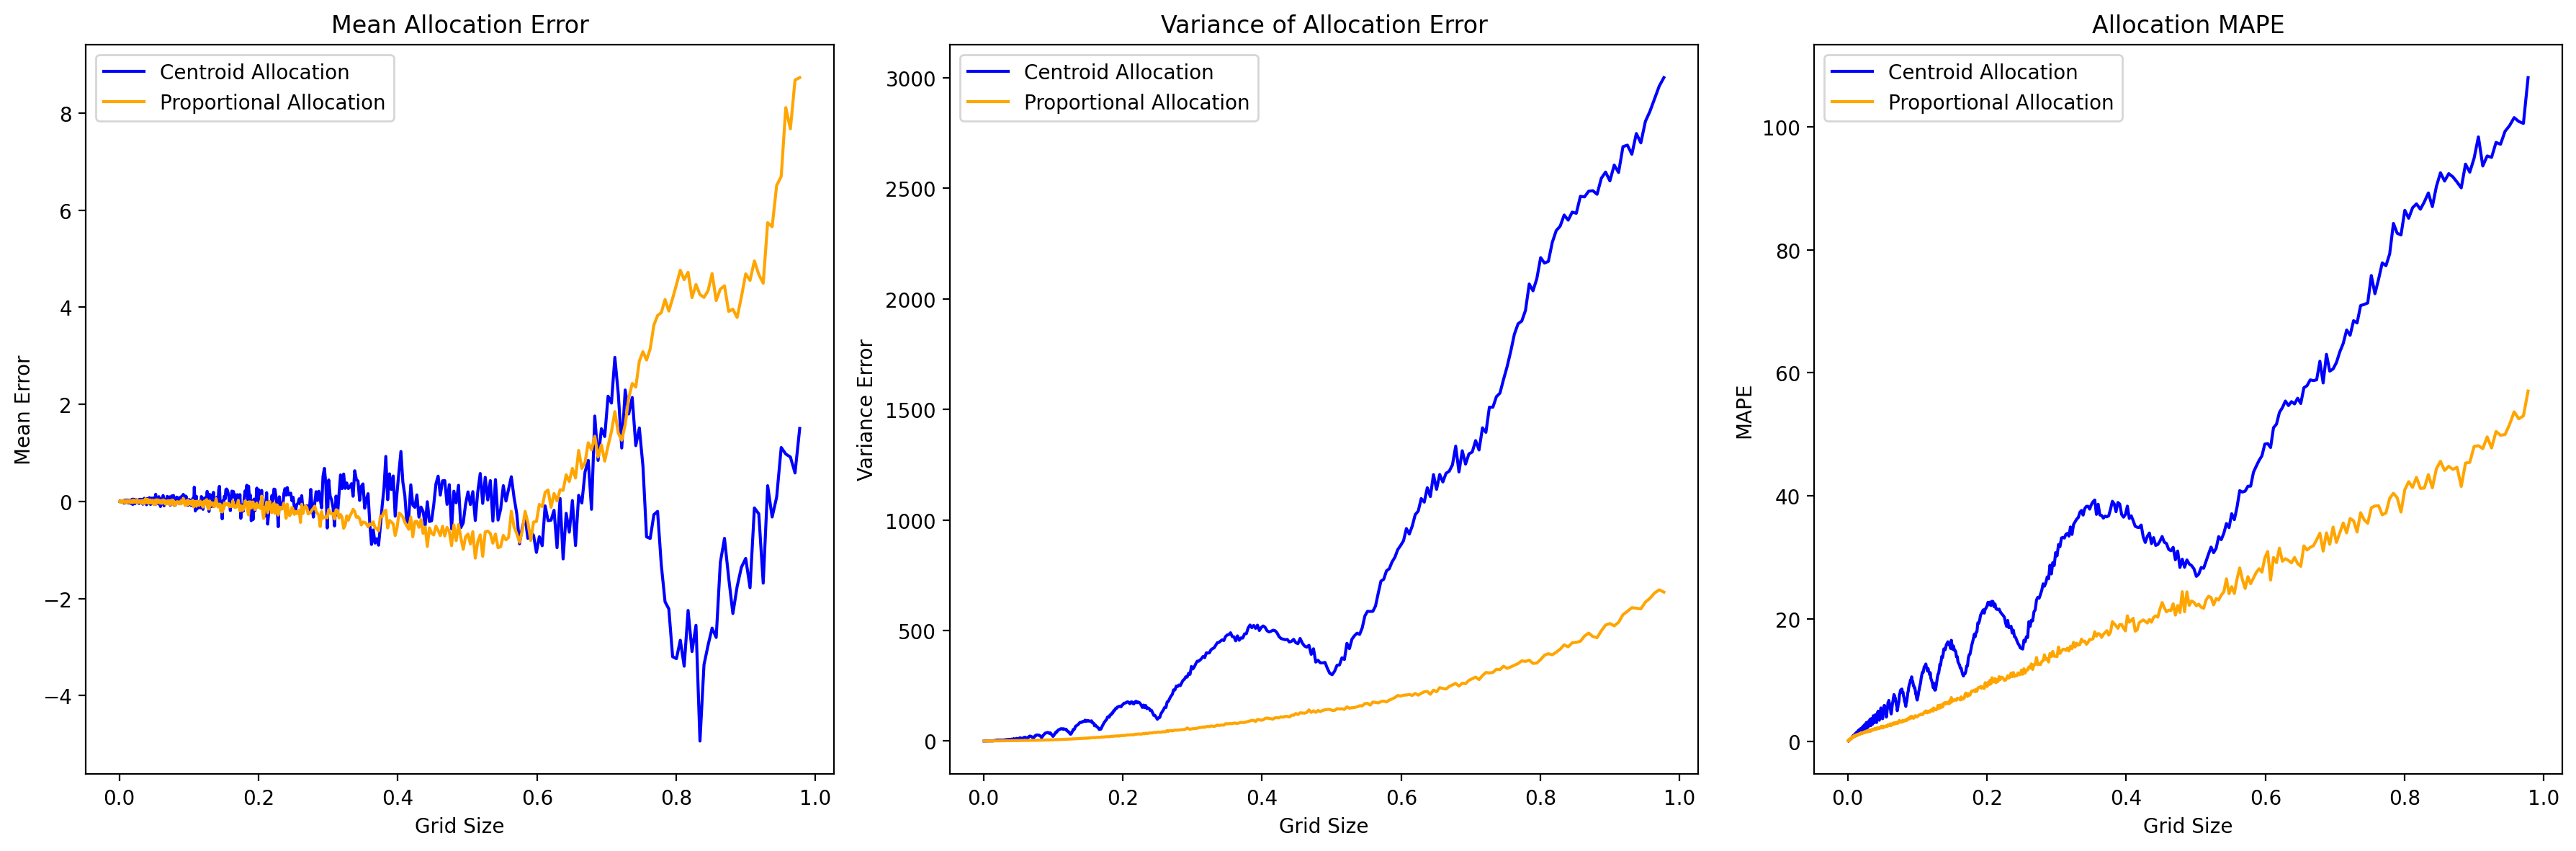

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].plot(dg, mean_estimate_centroid, label='Centroid Allocation', color='blue')
ax[0].plot(dg, mean_estimate_proportional, label='Proportional Allocation', color='orange')
ax[0].set_title('Mean Allocation Error')
ax[0].set_xlabel('Grid Size')
ax[0].set_ylabel('Mean Error')
ax[0].legend()
ax[1].plot(dg, var_estimate_centroid, label='Centroid Allocation', color='blue')
ax[1].plot(dg, var_estimate_proportional, label='Proportional Allocation', color='orange')
ax[1].set_title('Variance of Allocation Error')
ax[1].set_xlabel('Grid Size')
ax[1].set_ylabel('Variance Error')
ax[1].legend()
ax[2].plot(dg, mean_mape_centroid, label='Centroid Allocation', color='blue')
ax[2].plot(dg, mean_mape_proportional, label='Proportional Allocation', color='orange')
ax[2].set_title('Allocation MAPE')
ax[2].set_xlabel('Grid Size')
ax[2].set_ylabel('MAPE')
ax[2].legend()
plt.tight_layout()
plt.show()

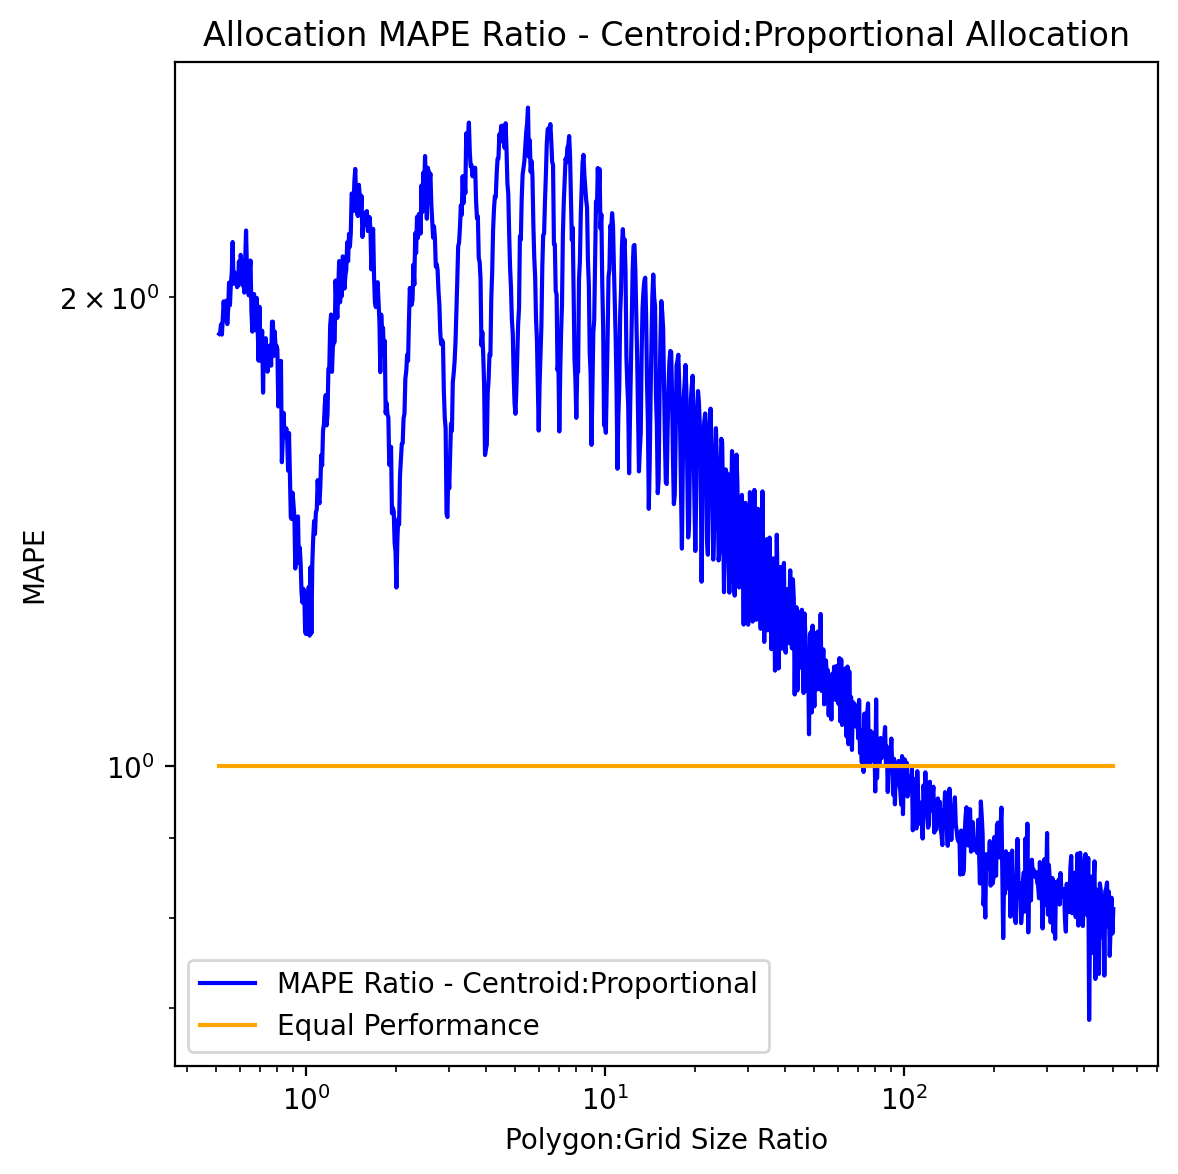

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.loglog(dp/dg, np.array(mean_mape_centroid) / np.array(mean_mape_proportional), label='MAPE Ratio - Centroid:Proportional', color='blue')
ax.loglog(dp/dg, np.ones(len(dg)), label='Equal Performance', color='orange')
ax.set_title('Allocation MAPE Ratio - Centroid:Proportional Allocation')
ax.set_xlabel('Polygon:Grid Size Ratio')
ax.set_ylabel('MAPE')
ax.legend()
plt.tight_layout()
plt.show()